## Allo - AI Engine Backend

[AMD AI Engine (AIE)](https://www.amd.com/en/products/adaptive-socs-and-fpgas/technologies/ai-engine.html) is a hardware accelerator specifically designed for AI applications. It is a TPU-like architecture with an array of AIE cores. In this tutorial, we target the AMD Ryzen 7040 and 8040 Series processors that are built on [AMD XDNA NPUs](https://www.amd.com/en/technologies/xdna.html), which are equipped with the second-generation AI Engine cores.

* Installation guide: <https://cornell-zhang.github.io/allo/backends/aie.html>
* MLIR-AIE Programming examples: <https://github.com/Xilinx/mlir-aie/tree/main/programming_examples>

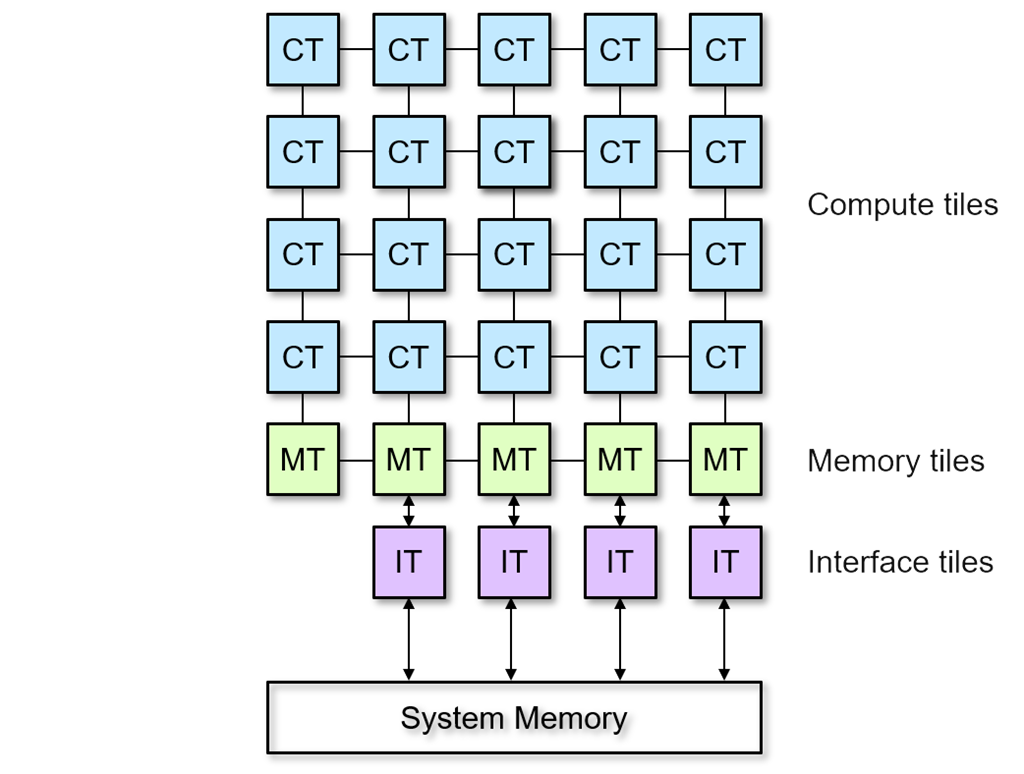

First let's import necessary packages.

In [ ]:
import allo
from allo.ir.types import int32
import allo.dataflow as df
import numpy as np

We leverage the same dataflow interface for the AIE backend, so we can easily retarget the original dataflow program from PL to AIE or other dataflow architectures.

### Single AIE Core

Here, we start from a simple kernel mapping with a single AIE core.

In [ ]:
Ty = int32
M = 1024

@df.region()
def top():
    @df.kernel(mapping=[1])
    def core(A: Ty[M], B: Ty[M], C: Ty[M]):
        C[:] = allo.add(A, B)

We can firstly run it using our builtin simulator.

In [ ]:
mod = df.build(top, target="simulator")
A = np.random.randint(0, 100, M).astype(np.int32)
B = np.random.randint(0, 100, M).astype(np.int32)
C = np.zeros(M).astype(np.int32)
mod(A, B, C)
np.testing.assert_allclose(C, A + B)
print("PASSED Simulation!")

Then we can call the `df.build` function and specify AIE as the target. It will automatically generate the MLIR-AIE code under `top.prj` folder and compile it using the Vitis AIE compiler to generate the executable. We can also check the intermediate files under `top.prj` to see if they are generated as expected.

In [ ]:
mod = df.build(top, target="aie")

Lastly, we can pass NumPy arrays to the module and run it as what we do for normal Allo programs. All the tedious host/device program specifications are hidden in our framework, so users can just push the button and get results.

In [ ]:
C = np.zeros(M).astype(np.int32)
mod(A, B, C)
np.testing.assert_allclose(C, A + B)
print("PASSED Execution!")

### Multi-AIE Core

In the next example, we map the kernel to multiple AIE cores. To achieve this, we only need to change the `mapping` argument of the decorator. The rest of the code just stays the same.

In [ ]:
Ty = int32
M = 1024
P0 = 4
Mt = M // P0

@df.region()
def top():
    @df.kernel(mapping=[P0])
    def core(A: Ty[M], B: Ty[M], C: Ty[M]):
        pi = df.get_pid()
        C[pi * Mt : (pi + 1) * Mt] = allo.add(
            A[pi * Mt : (pi + 1) * Mt], B[pi * Mt : (pi + 1) * Mt]
        )

mod = df.build(top, target="aie")
A = np.random.randint(0, 100, M).astype(np.int32)
B = np.random.randint(0, 100, M).astype(np.int32)
C = np.zeros(M).astype(np.int32)
mod(A, B, C)
np.testing.assert_allclose(C, A + B)
print("PASSED!")

Lastly, we use a GEMM example to show the 2D mapping flow. As it involves reduction (dot product) along the row of `A` and the column of `B`, in Allo we have provided a `matmul` operator to directly map the computation to the AIE core, which reduces the burden of writing nested loops.

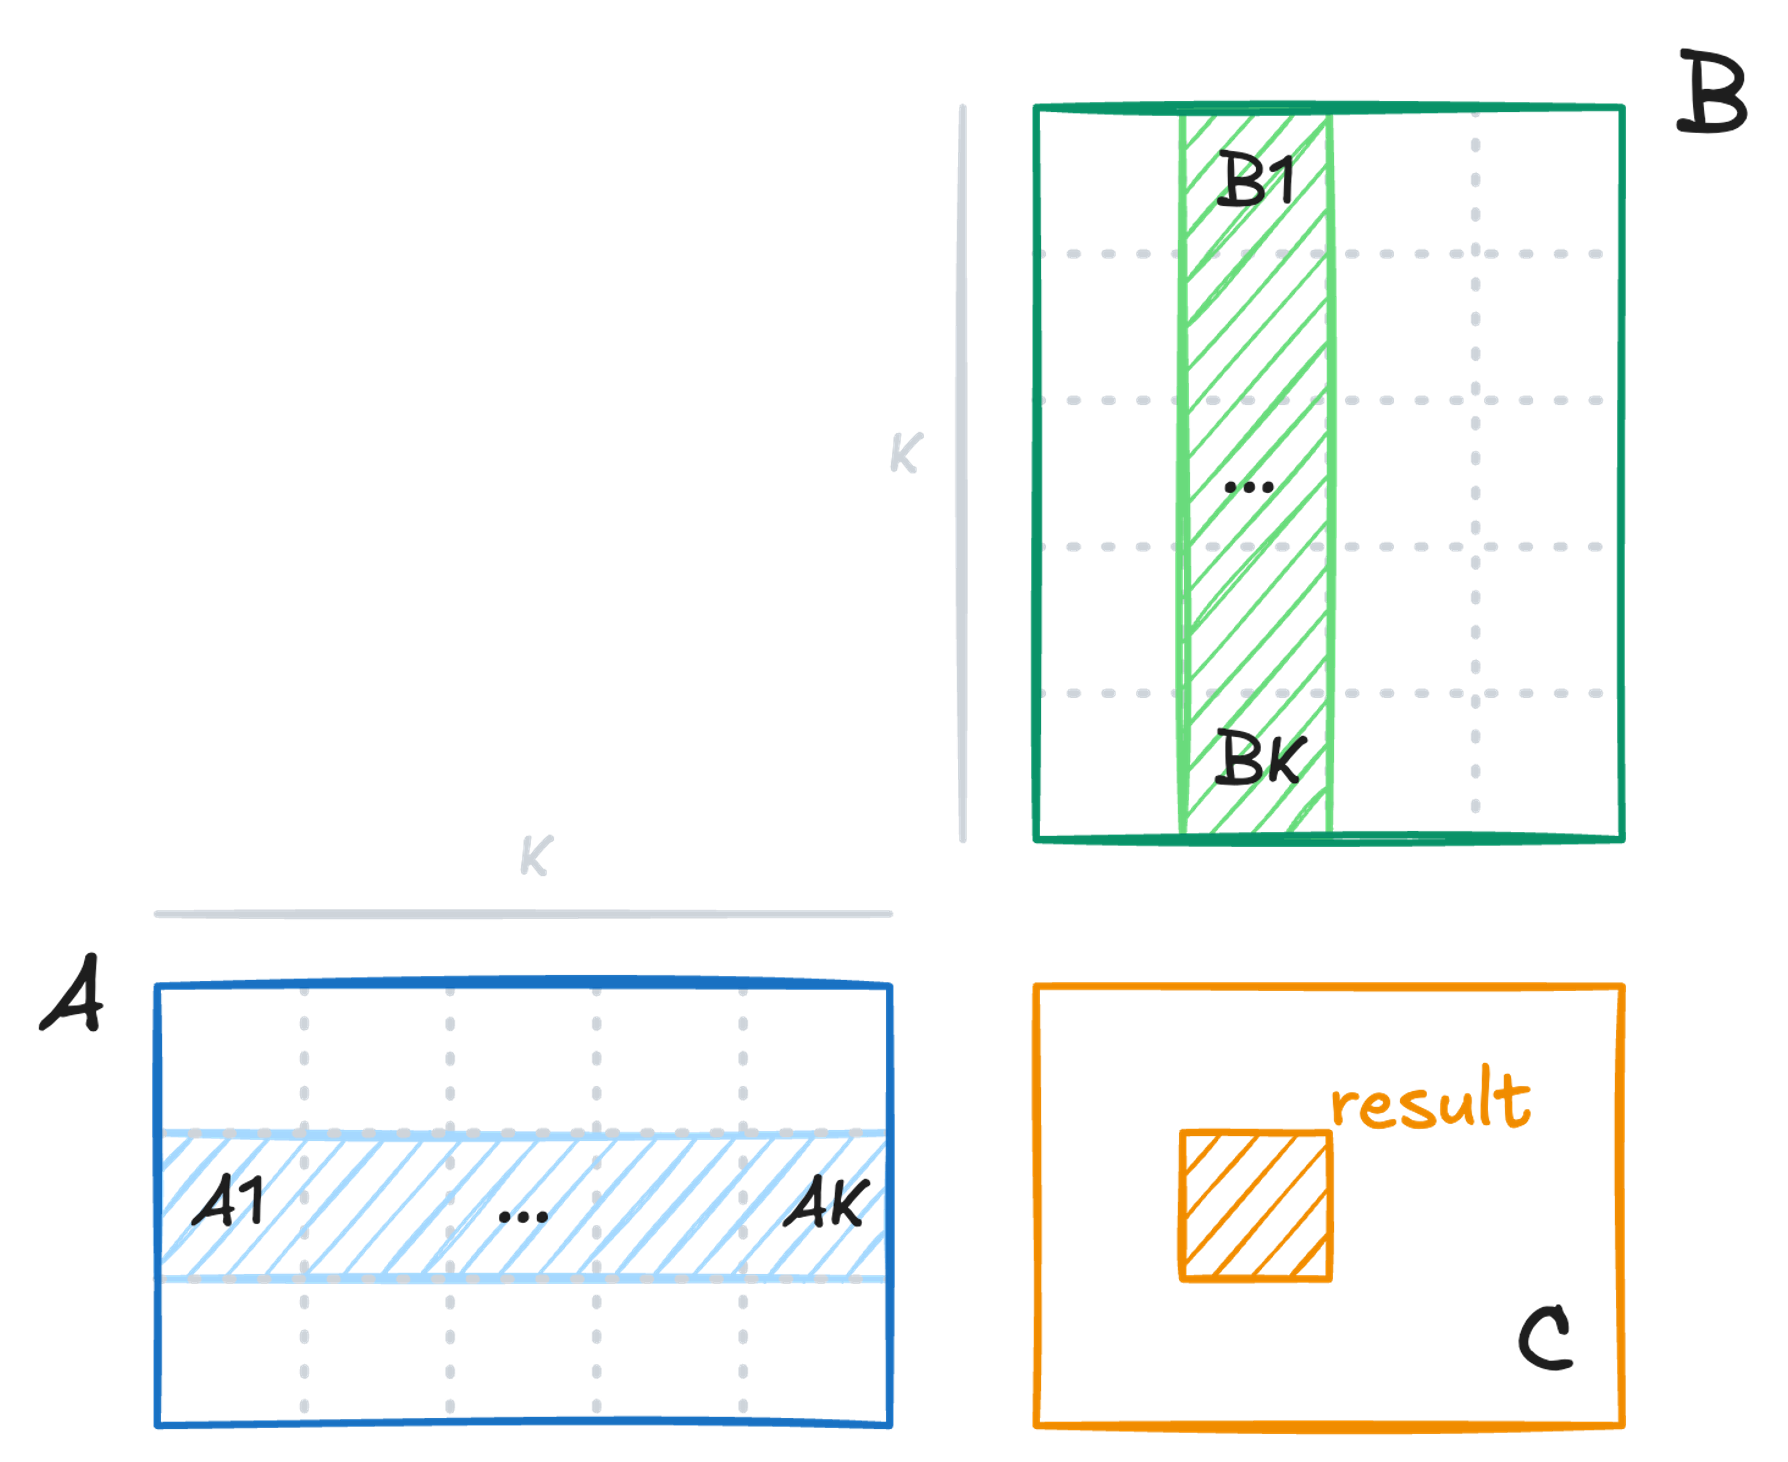

In [ ]:
Ty = int32
M, N, K = 16, 16, 16
P0, P1 = 2, 2
Mt, Nt = M // P0, N // P1

@df.region()
def top():
    @df.kernel(mapping=[P0, P1])
    def gemm(A: Ty[M, K], B: Ty[K, N], C: Ty[M, N]):
        p0, p1 = df.get_pid()
        C[p0 * Mt : (p0 + 1) * Mt, p1 * Nt : (p1 + 1) * Nt] = allo.matmul(
            A[p0 * Mt : (p0 + 1) * Mt, :], B[:, p1 * Nt : (p1 + 1) * Nt]
        )
mod = df.build(top, target="aie")
A = np.random.randint(0, 64, (M, K)).astype(np.int32)
B = np.random.randint(0, 64, (K, N)).astype(np.int32)
C = np.zeros((M, N)).astype(np.int32)
mod(A, B, C)
np.testing.assert_allclose(C, A @ B, atol=1e-5)
print("PASSED!")

## Conclusion
* https://github.com/cornell-zhang/allo